# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

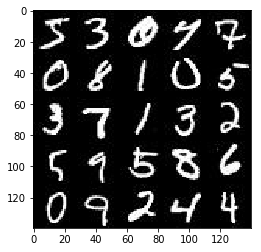

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

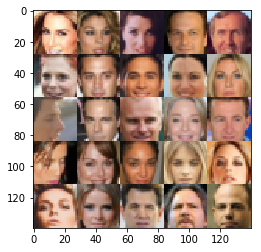

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'input_image')
    input_z = tf.placeholder(tf.float32, (None, z_dim), 'input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_image, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(features, alpha):
    return tf.maximum(features, alpha*features)

In [7]:
def discriminator(images, reuse=False, alpha=.2, drop_prob=.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    activation = lambda x : leaky_relu(x, alpha)
    with tf.variable_scope('discriminator', reuse=reuse):
        # starts - 28 x 28 x ?
        l1 = tf.layers.conv2d(images, 64, 5, 2, 'same', activation=activation)
        l1 = tf.layers.dropout(l1, drop_prob)
        # 14x14x64
        l2 = tf.layers.conv2d(l1, 128, 5, 1, 'same')
        l2 = tf.layers.batch_normalization(l2, True)
        l2 = activation(l2)
        l2 = tf.layers.dropout(l2, drop_prob)
        # 14x14x128
        l3 = tf.layers.conv2d(l2, 256, 5, 2, 'same')
        l3 = tf.layers.batch_normalization(l3, True)
        l3 = activation(l3)
        l3 = tf.layers.dropout(l3, drop_prob)
        # 7x7x256
        
        flat = tf.reshape(l3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        l1 = tf.layers.dense(z, 7*7*256)
        l1 = tf.reshape(l1, (-1, 7, 7, 256))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.nn.relu(l1)
        # 7x7x256
        
        l2 = tf.layers.conv2d_transpose(l1, 128, 5, 2, 'same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.nn.relu(l2)
        # 14x14x128
        
        l3 = tf.layers.conv2d_transpose(l2, 64, 5, 1, 'same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.nn.relu(l3)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
        # 28x28x?
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=.2, smooth=.1, drop_prob=.5):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, drop_prob=drop_prob)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, drop_prob=drop_prob)
    
    calc_loss = lambda logits, labels: tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits,
            labels=labels))
    
    
    d_loss_real = calc_loss(d_logits_real, tf.ones_like(d_model_real)*(1-smooth))
    d_loss_fake = calc_loss(d_logits_fake, tf.zeros_like(d_model_fake))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = calc_loss(d_logits_fake, tf.ones_like(d_model_fake))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'discriminator' in str(var)]
    g_vars = [var for var in t_vars if 'generator' in str(var)]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
import sys

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    params = []
    params.extend(data_shape[1:])
    params.extend([z_dim])
    
    graph = tf.Graph()
    with graph.as_default():
        input_real, input_z, lr = model_inputs(*params)

        d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
        d_opt,  g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                d_feed = {input_real: batch_images, input_z: batch_z}
                g_feed = {input_z: batch_z}
                _ = sess.run(d_opt, d_feed)
                _ = sess.run(g_opt, g_feed)
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(d_feed)
                    train_loss_g = g_loss.eval(g_feed)
                    sys.stdout.write('\rEpoch: {}/{}; D-Loss: {}; G-Loss: {}'.format(
                        epoch_i+1, epoch_count, train_loss_d, train_loss_g))
                
                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2; D-Loss: 1.1481165885925293; G-Loss: 1.2180266380310059

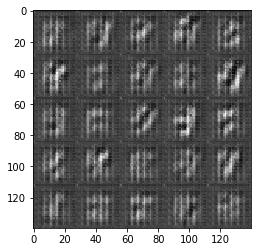

Epoch: 1/2; D-Loss: 1.0079408884048462; G-Loss: 1.2174866199493408

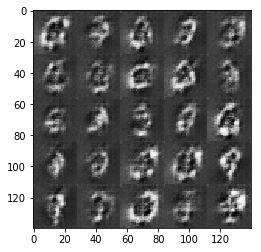

Epoch: 1/2; D-Loss: 0.9181458950042725; G-Loss: 1.0858962535858154

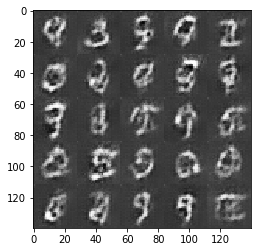

Epoch: 1/2; D-Loss: 1.4619438648223877; G-Loss: 0.4785296320915222

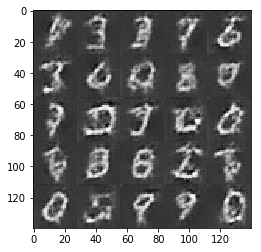

Epoch: 1/2; D-Loss: 1.817927360534668; G-Loss: 0.289497107267379763

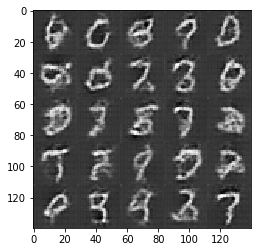

Epoch: 1/2; D-Loss: 1.0495378971099854; G-Loss: 0.9248999357223511

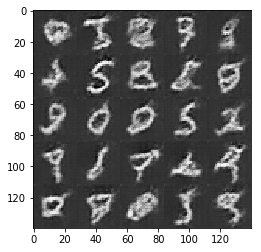

Epoch: 1/2; D-Loss: 1.3862993717193604; G-Loss: 0.6706736087799072

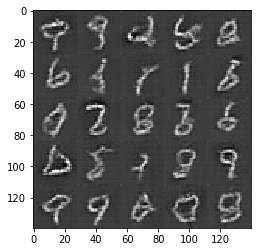

Epoch: 1/2; D-Loss: 1.2530776262283325; G-Loss: 2.1881732940673834

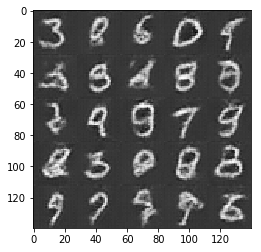

Epoch: 1/2; D-Loss: 1.0853214263916016; G-Loss: 0.8958512544631958

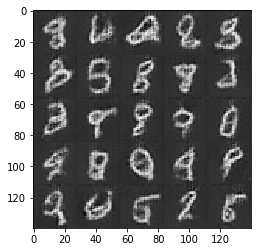

Epoch: 2/2; D-Loss: 0.942585289478302; G-Loss: 1.30338811874389659

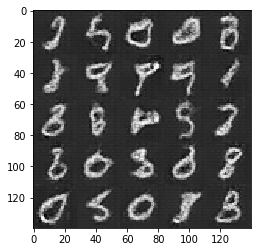

Epoch: 2/2; D-Loss: 0.9467734098434448; G-Loss: 1.3363608121871948

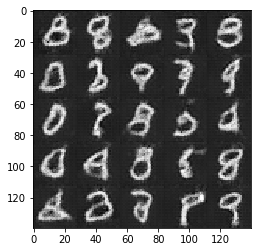

Epoch: 2/2; D-Loss: 1.156005620956421; G-Loss: 0.70064818859100342

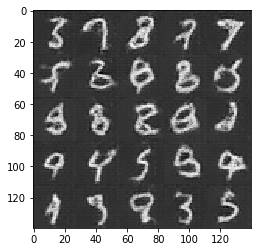

Epoch: 2/2; D-Loss: 1.1358962059020996; G-Loss: 1.7336883544921875

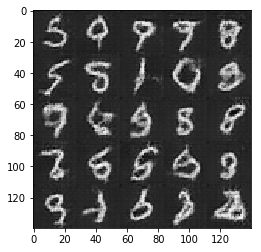

Epoch: 2/2; D-Loss: 0.834510862827301; G-Loss: 1.76423716545104985

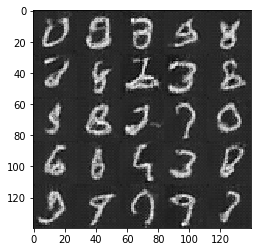

Epoch: 2/2; D-Loss: 0.9849996566772461; G-Loss: 1.2297362089157104

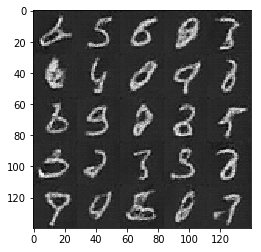

Epoch: 2/2; D-Loss: 0.8773013949394226; G-Loss: 1.3726747035980225

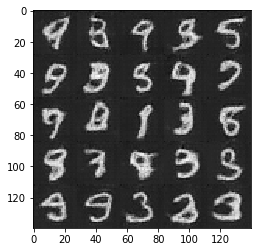

Epoch: 2/2; D-Loss: 0.7996737957000732; G-Loss: 1.6705212593078613

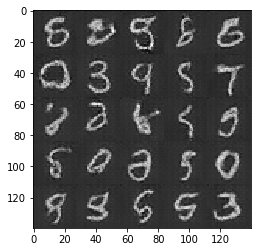

Epoch: 2/2; D-Loss: 0.9492105841636658; G-Loss: 1.92069649696350166

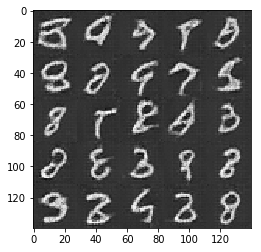

Epoch: 2/2; D-Loss: 0.8441381454467773; G-Loss: 1.6663274765014648

In [14]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/5; D-Loss: 1.1140086650848389; G-Loss: 1.1184475421905518

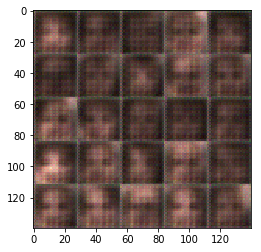

Epoch: 1/5; D-Loss: 1.4591538906097412; G-Loss: 0.7265771031379762

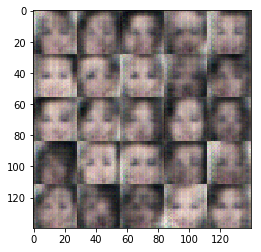

Epoch: 1/5; D-Loss: 1.5633379220962524; G-Loss: 0.7639427781105042

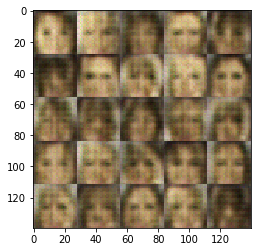

Epoch: 1/5; D-Loss: 0.926445722579956; G-Loss: 1.39522600173950253

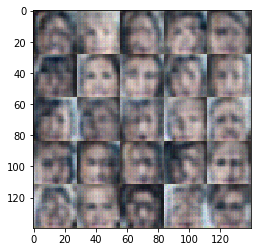

Epoch: 1/5; D-Loss: 0.7963892817497253; G-Loss: 1.4608349800109863

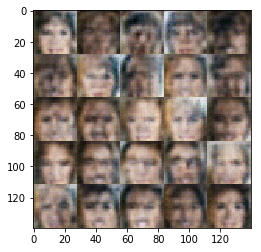

Epoch: 1/5; D-Loss: 0.7066982984542847; G-Loss: 1.8406317234039307

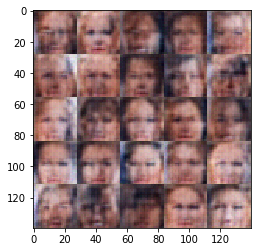

Epoch: 1/5; D-Loss: 0.42218464612960815; G-Loss: 3.215395450592041

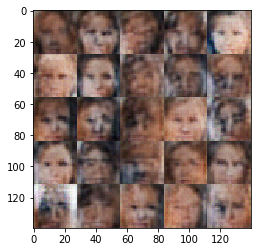

Epoch: 1/5; D-Loss: 1.1969414949417114; G-Loss: 0.73781436681747443

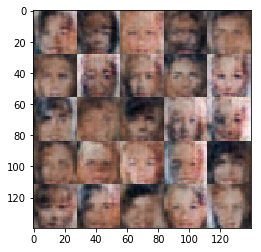

Epoch: 1/5; D-Loss: 0.8324939608573914; G-Loss: 2.34143757820129475

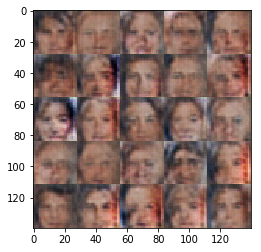

Epoch: 1/5; D-Loss: 0.6687501072883606; G-Loss: 3.4537816047668457

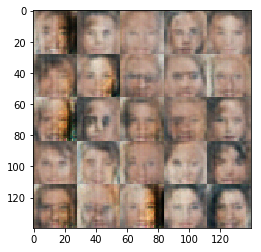

Epoch: 1/5; D-Loss: 0.7020092010498047; G-Loss: 1.5164397954940796

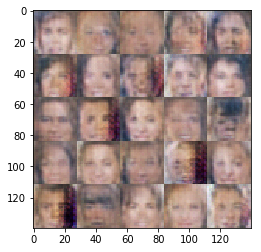

Epoch: 1/5; D-Loss: 0.49581512808799744; G-Loss: 2.859168052673347

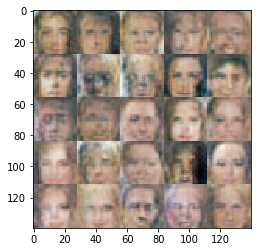

Epoch: 1/5; D-Loss: 1.5800492763519287; G-Loss: 0.4682237207889557

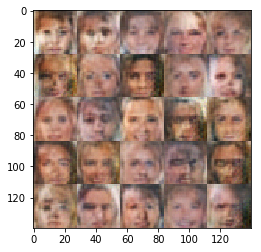

Epoch: 1/5; D-Loss: 0.609418511390686; G-Loss: 4.29281234741210963

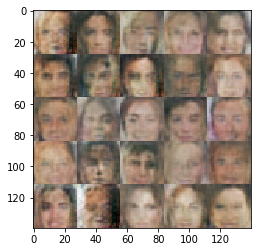

Epoch: 1/5; D-Loss: 0.48348087072372437; G-Loss: 2.7425622940063477

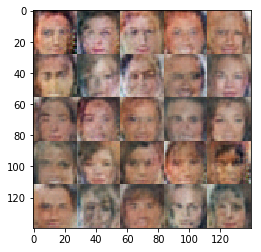

Epoch: 1/5; D-Loss: 0.5821149349212646; G-Loss: 4.9278373718261726

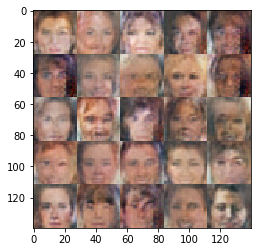

Epoch: 1/5; D-Loss: 1.0264053344726562; G-Loss: 2.8774132728576665

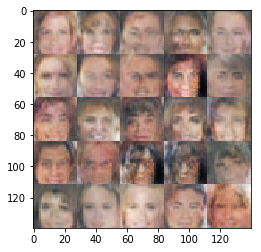

Epoch: 1/5; D-Loss: 0.5860687494277954; G-Loss: 2.9703273773193365

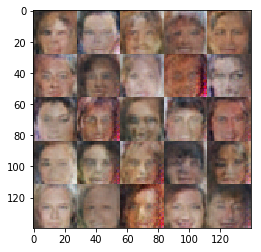

Epoch: 1/5; D-Loss: 0.6435993909835815; G-Loss: 3.63618516921997076

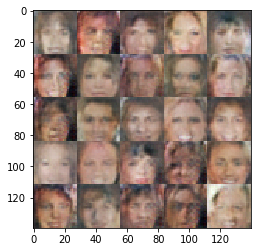

Epoch: 1/5; D-Loss: 1.079034686088562; G-Loss: 0.96744692325592042

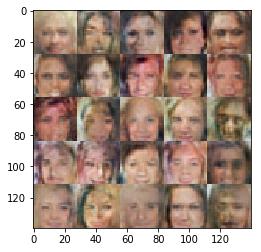

Epoch: 1/5; D-Loss: 1.0110445022583008; G-Loss: 1.20622086524963385

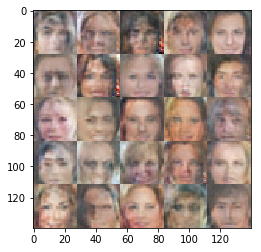

Epoch: 1/5; D-Loss: 0.8460446000099182; G-Loss: 2.0242614746093753

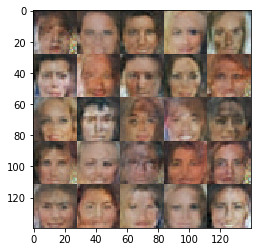

Epoch: 1/5; D-Loss: 0.7529358863830566; G-Loss: 4.5526633262634285

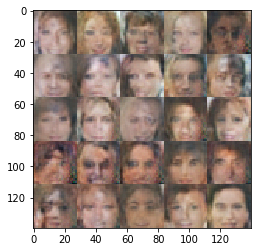

Epoch: 1/5; D-Loss: 0.7922592759132385; G-Loss: 1.4229662418365479

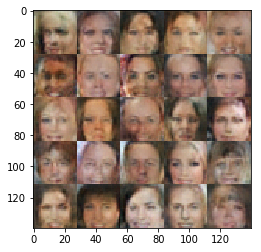

Epoch: 1/5; D-Loss: 0.6910529136657715; G-Loss: 1.6274940967559814

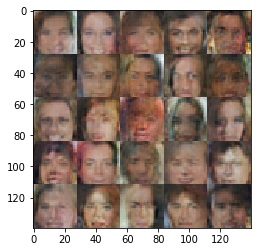

Epoch: 1/5; D-Loss: 0.9800381660461426; G-Loss: 1.1488592624664307

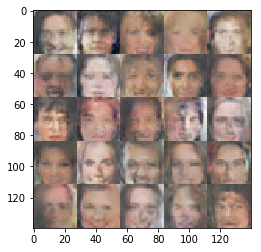

Epoch: 1/5; D-Loss: 0.8593346476554871; G-Loss: 1.37157797813415535

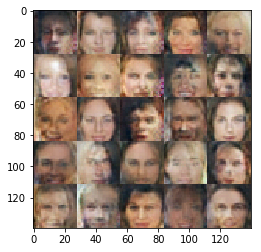

Epoch: 1/5; D-Loss: 0.7570624947547913; G-Loss: 1.5945075750350952

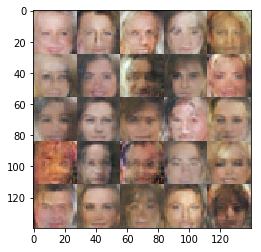

Epoch: 1/5; D-Loss: 0.780299186706543; G-Loss: 1.69363021850585947

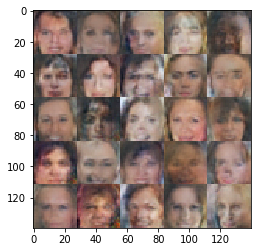

Epoch: 1/5; D-Loss: 0.9657467603683472; G-Loss: 0.9786395430564885

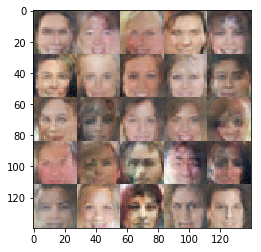

Epoch: 1/5; D-Loss: 0.9839333295822144; G-Loss: 1.1348319053649902

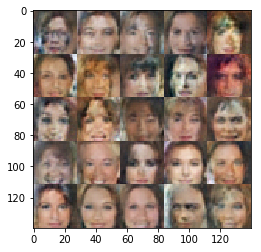

Epoch: 2/5; D-Loss: 0.5502302646636963; G-Loss: 2.7846758365631104

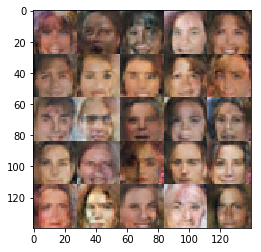

Epoch: 2/5; D-Loss: 1.0760104656219482; G-Loss: 0.9391564130783081

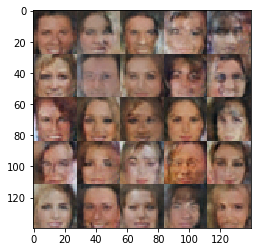

Epoch: 2/5; D-Loss: 1.2379220724105835; G-Loss: 1.61106443405151377

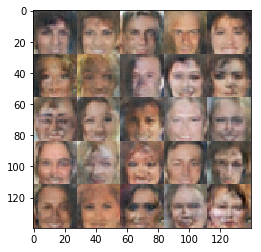

Epoch: 2/5; D-Loss: 0.9015443921089172; G-Loss: 1.0346724987030031

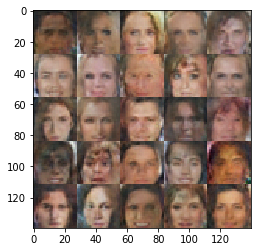

Epoch: 2/5; D-Loss: 0.6461342573165894; G-Loss: 2.3934462070465096

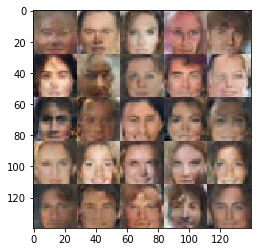

Epoch: 2/5; D-Loss: 1.1309175491333008; G-Loss: 1.0701491832733154

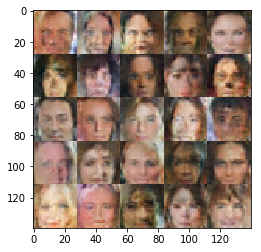

Epoch: 2/5; D-Loss: 0.9738942384719849; G-Loss: 1.4675115346908574

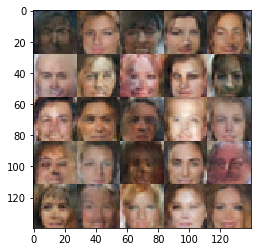

Epoch: 2/5; D-Loss: 1.103366732597351; G-Loss: 0.75080889463424688

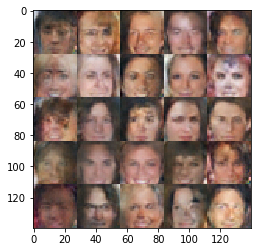

Epoch: 2/5; D-Loss: 1.0256400108337402; G-Loss: 1.0088413953781128

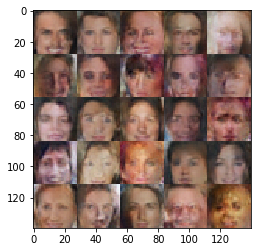

Epoch: 2/5; D-Loss: 0.7760230898857117; G-Loss: 1.6687290668487549

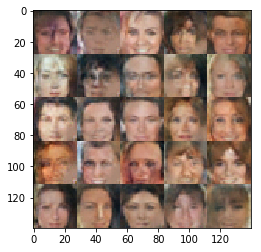

Epoch: 2/5; D-Loss: 0.7533323168754578; G-Loss: 1.5774793624877938

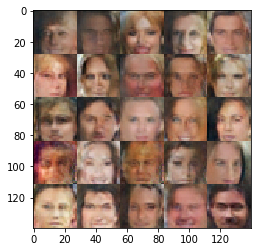

Epoch: 2/5; D-Loss: 0.9050965309143066; G-Loss: 1.1346198320388794

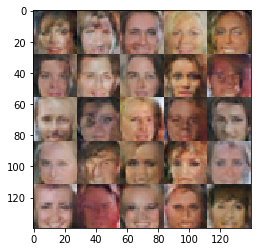

Epoch: 2/5; D-Loss: 1.0139567852020264; G-Loss: 1.2065140008926392

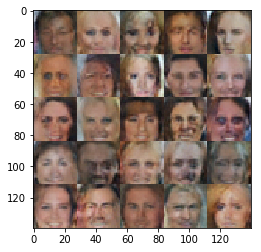

Epoch: 2/5; D-Loss: 0.8840619325637817; G-Loss: 1.2037212848663336

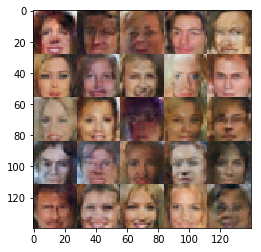

Epoch: 2/5; D-Loss: 0.7910323143005371; G-Loss: 1.7755305767059326

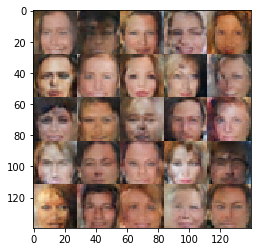

Epoch: 2/5; D-Loss: 1.1595739126205444; G-Loss: 1.6788630485534668

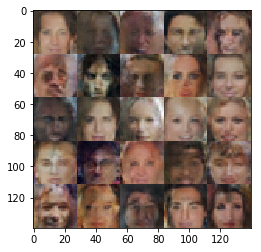

Epoch: 2/5; D-Loss: 1.091566801071167; G-Loss: 0.81270265579223633

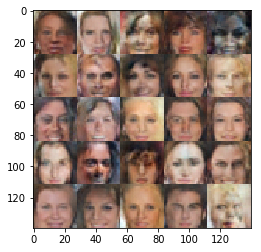

Epoch: 2/5; D-Loss: 1.3865764141082764; G-Loss: 0.5680354833602905

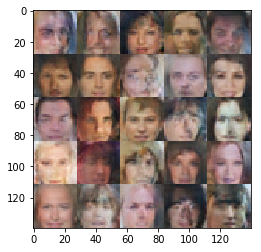

Epoch: 2/5; D-Loss: 0.6821296215057373; G-Loss: 1.68747520446777345

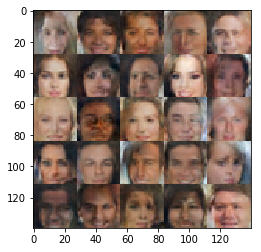

Epoch: 2/5; D-Loss: 0.9961377382278442; G-Loss: 3.72544860839843753

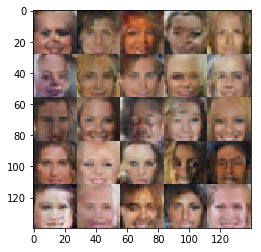

Epoch: 2/5; D-Loss: 1.6232643127441406; G-Loss: 1.0321143865585327

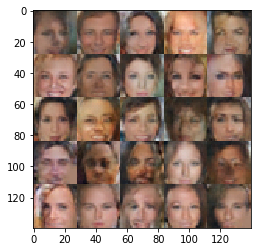

Epoch: 2/5; D-Loss: 1.1988370418548584; G-Loss: 0.7286800146102905

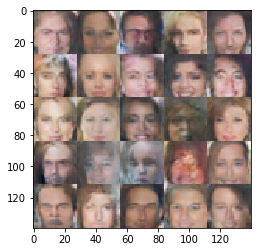

Epoch: 2/5; D-Loss: 1.090268850326538; G-Loss: 1.299720525741577186

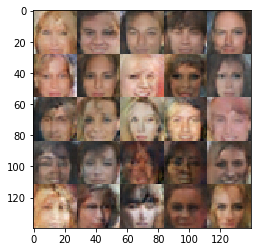

Epoch: 2/5; D-Loss: 0.7420724630355835; G-Loss: 1.6211477518081665

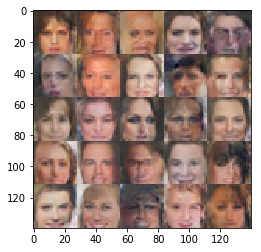

Epoch: 2/5; D-Loss: 1.0064613819122314; G-Loss: 1.2510390281677246

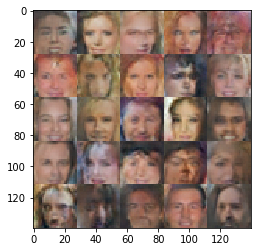

Epoch: 2/5; D-Loss: 0.5959663987159729; G-Loss: 2.0723960399627686

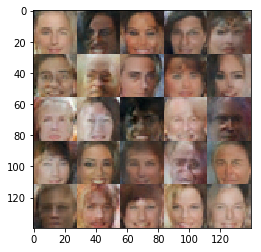

Epoch: 2/5; D-Loss: 1.0192110538482666; G-Loss: 0.9583607912063599

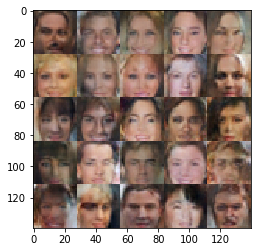

Epoch: 2/5; D-Loss: 0.9369373321533203; G-Loss: 1.36481022834777834

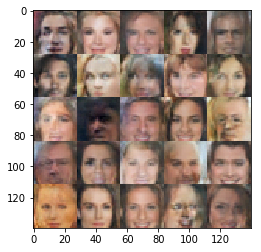

Epoch: 2/5; D-Loss: 1.0864657163619995; G-Loss: 1.1644303798675537

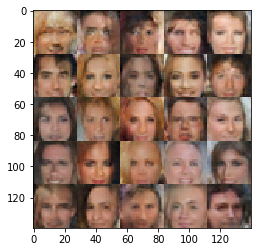

Epoch: 2/5; D-Loss: 0.5658755898475647; G-Loss: 2.3683714866638184

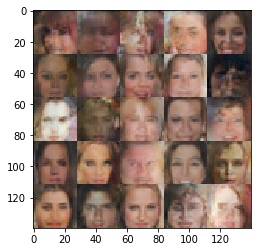

Epoch: 2/5; D-Loss: 1.129806399345398; G-Loss: 0.88312643766403262

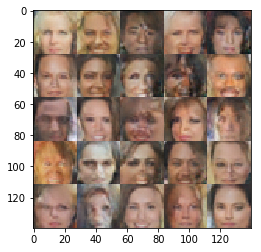

Epoch: 2/5; D-Loss: 1.0040384531021118; G-Loss: 1.0364190340042114

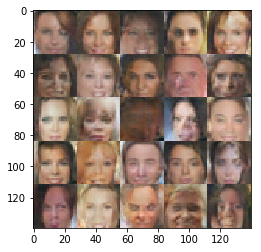

Epoch: 3/5; D-Loss: 1.0639994144439697; G-Loss: 1.0188384056091309

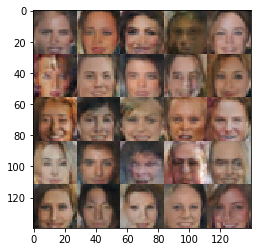

Epoch: 3/5; D-Loss: 0.7766652703285217; G-Loss: 2.00292539596557645

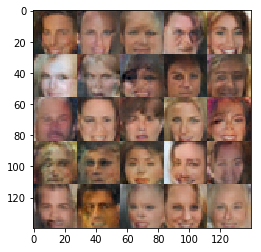

Epoch: 3/5; D-Loss: 0.6155189275741577; G-Loss: 3.6921696662902835

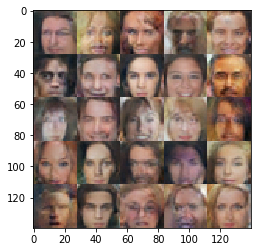

Epoch: 3/5; D-Loss: 0.9748551845550537; G-Loss: 0.9646116495132446

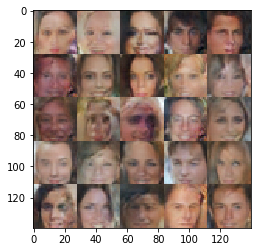

Epoch: 3/5; D-Loss: 1.0237722396850586; G-Loss: 0.9922030568122864

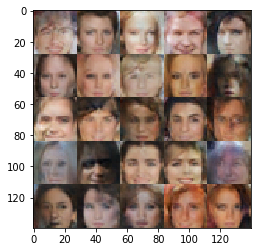

Epoch: 3/5; D-Loss: 0.7775906920433044; G-Loss: 1.5489003658294678

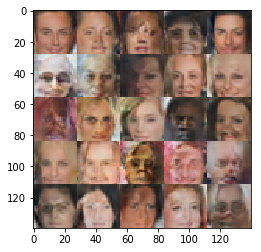

Epoch: 3/5; D-Loss: 0.9145202040672302; G-Loss: 1.30166053771972667

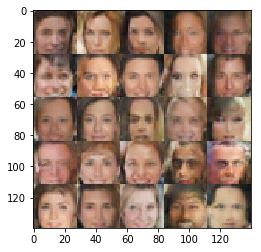

Epoch: 3/5; D-Loss: 0.8815707564353943; G-Loss: 3.76362419128417974

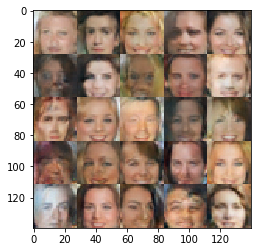

Epoch: 3/5; D-Loss: 1.0718069076538086; G-Loss: 0.9738398790359497

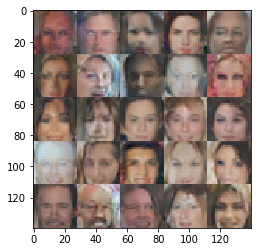

Epoch: 3/5; D-Loss: 0.8932080864906311; G-Loss: 1.1534540653228763

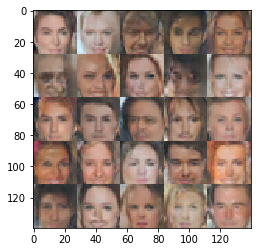

Epoch: 3/5; D-Loss: 1.0864405632019043; G-Loss: 1.2221353054046637

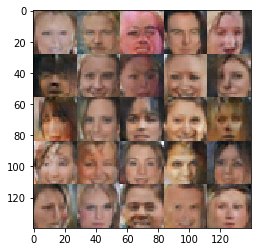

Epoch: 3/5; D-Loss: 1.003888726234436; G-Loss: 1.29725146293640145

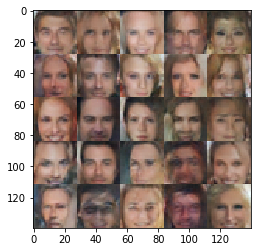

Epoch: 3/5; D-Loss: 1.2800312042236328; G-Loss: 1.1623855829238892

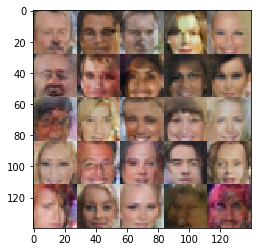

Epoch: 3/5; D-Loss: 0.9154378771781921; G-Loss: 1.0401809215545654

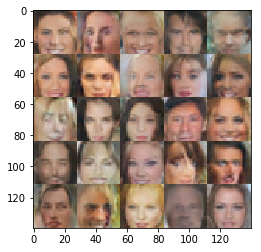

Epoch: 3/5; D-Loss: 1.3443036079406738; G-Loss: 0.5779082179069519

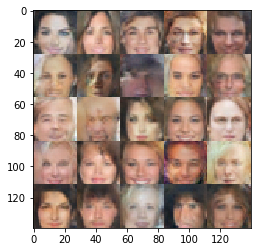

Epoch: 3/5; D-Loss: 0.8074813485145569; G-Loss: 1.6075681447982788

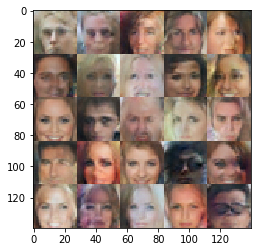

Epoch: 3/5; D-Loss: 1.1575599908828735; G-Loss: 0.8774029016494751

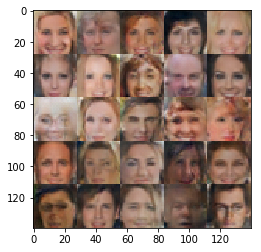

Epoch: 3/5; D-Loss: 1.2846652269363403; G-Loss: 0.6954696178436279

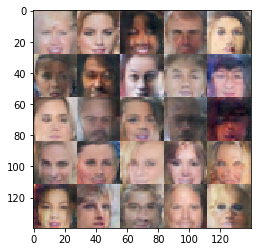

Epoch: 3/5; D-Loss: 1.079856276512146; G-Loss: 0.93525469303131136

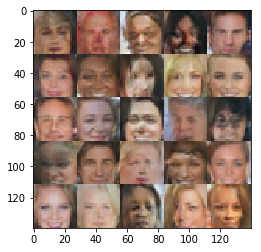

Epoch: 3/5; D-Loss: 1.0949493646621704; G-Loss: 1.2452213764190674

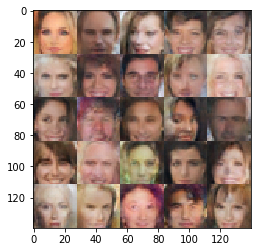

Epoch: 3/5; D-Loss: 0.8909568786621094; G-Loss: 1.0695819854736328

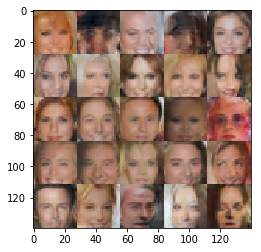

Epoch: 3/5; D-Loss: 0.8274228572845459; G-Loss: 1.3957309722900391

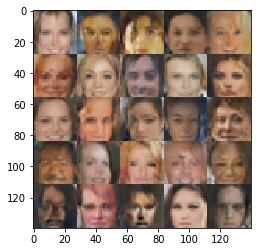

Epoch: 3/5; D-Loss: 1.236149549484253; G-Loss: 0.88534295558929445

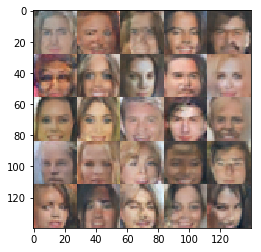

Epoch: 3/5; D-Loss: 1.101872205734253; G-Loss: 1.20078301429748544

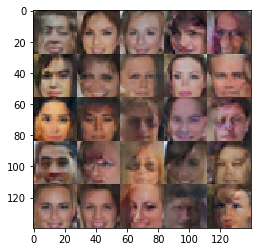

Epoch: 3/5; D-Loss: 1.1169285774230957; G-Loss: 0.9441279768943787

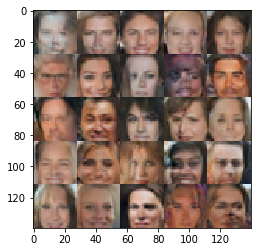

Epoch: 3/5; D-Loss: 1.2656426429748535; G-Loss: 0.8048992156982422

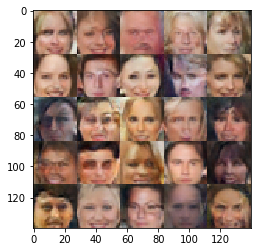

Epoch: 3/5; D-Loss: 1.1551876068115234; G-Loss: 0.8190551400184631

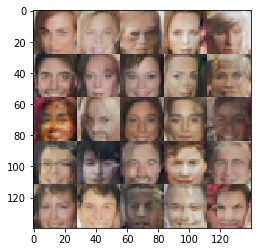

Epoch: 3/5; D-Loss: 0.7843933701515198; G-Loss: 1.8889213800430298

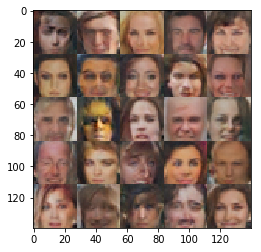

Epoch: 3/5; D-Loss: 1.0545082092285156; G-Loss: 1.3095479011535645

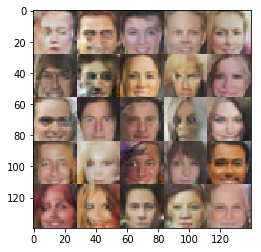

Epoch: 3/5; D-Loss: 1.1093693971633911; G-Loss: 0.8799366354942322

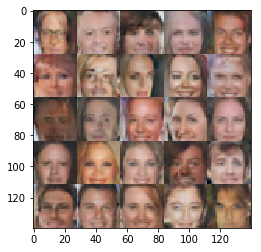

Epoch: 3/5; D-Loss: 1.1923781633377075; G-Loss: 0.6335855722427368

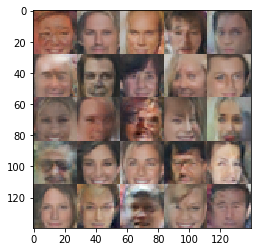

Epoch: 4/5; D-Loss: 0.9754645228385925; G-Loss: 1.4023673534393317

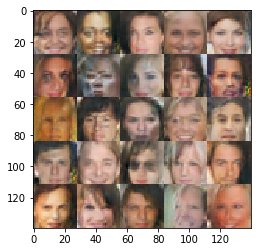

Epoch: 4/5; D-Loss: 1.005335807800293; G-Loss: 0.84696066379547122

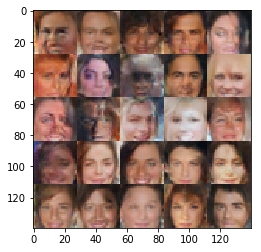

Epoch: 4/5; D-Loss: 1.0677887201309204; G-Loss: 1.01962614059448244

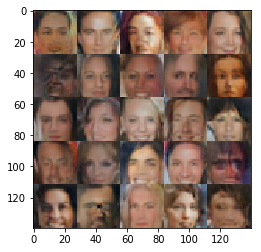

Epoch: 4/5; D-Loss: 0.9496551752090454; G-Loss: 1.1387515068054248

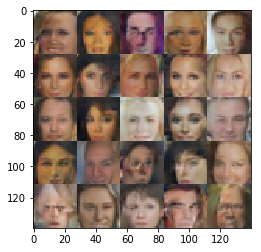

Epoch: 4/5; D-Loss: 1.3637806177139282; G-Loss: 1.4869780540466309

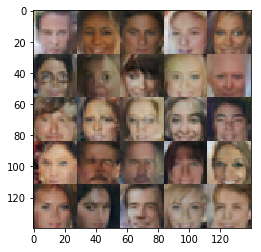

Epoch: 4/5; D-Loss: 1.0227025747299194; G-Loss: 1.3004601001739502

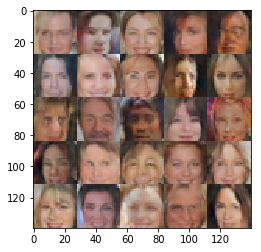

Epoch: 4/5; D-Loss: 1.1298425197601318; G-Loss: 0.8992975950241089

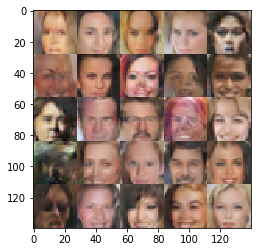

Epoch: 4/5; D-Loss: 1.2372362613677979; G-Loss: 0.6463460326194763

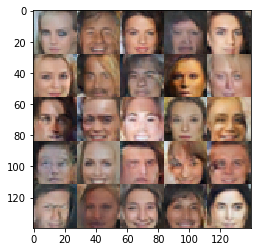

Epoch: 4/5; D-Loss: 1.0948028564453125; G-Loss: 1.0398324728012085

KeyboardInterrupt: 

In [15]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.